In [1]:
import pandas as pd
import os, math, itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
base_path = "./images"

si_paths = []
for i in range(1, 61):
    path = os.path.join(base_path, f"si_{i:02d}.jpeg")
    if os.path.exists(path):
        si_paths.append(path)

mo_paths = []
for i in range(1, 61):
    path = os.path.join(base_path, f"mo_{i:02d}.jpeg")
    if os.path.exists(path):
        mo_paths.append(path)

print(f"Found {len(si_paths)} 'silla' images and {len(mo_paths)} 'monitor' images.")

Found 60 'silla' images and 60 'monitor' images.


In [3]:
si_classes = ["silla"] * len(si_paths)
mo_classes = ["monitor"] * len(mo_paths)

In [4]:
data = {
    "path": si_paths + mo_paths,
    "class": si_classes + mo_classes
}

df = pd.DataFrame(data)

In [5]:
df.head()

,path,class
0,./images\si_01.jpeg,silla
1,./images\si_02.jpeg,silla
2,./images\si_03.jpeg,silla
3,./images\si_04.jpeg,silla
4,./images\si_05.jpeg,silla


In [6]:
X = df["path"]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=336
)


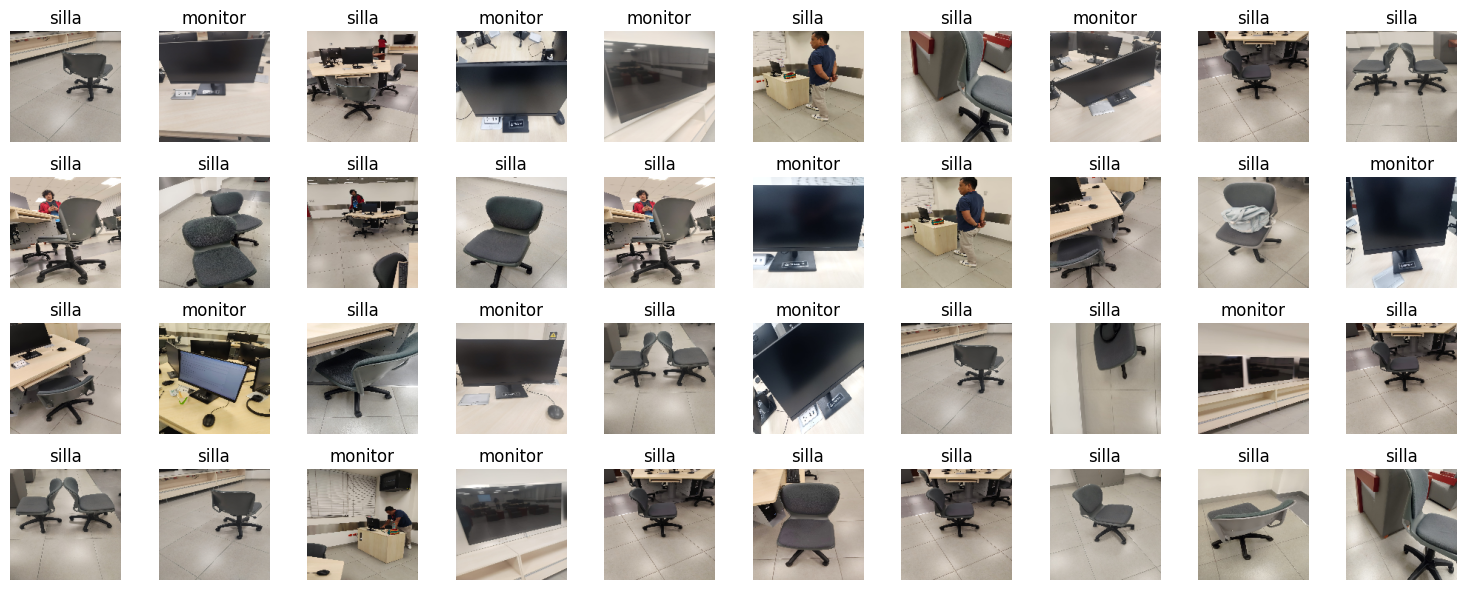

In [7]:
cols, rows = 10, 4
plt.figure(figsize=(cols * 1.5, rows * 1.5))

img_height = 150
img_width = 150

for i in range(cols * rows):
    idx = np.random.randint(0, len(X_train))

    img_path = X_train.iloc[idx]
    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)

    plt.subplot(rows, cols, i+1)
    plt.imshow(img_array.astype('uint8'))
    plt.title(y_train.iloc[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train,
    test_size=0.4,
    stratify=y_train,
    random_state=336
)

In [9]:
batch_size = 128

class_names = ['silla', 'monitor']

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

def load_and_preprocess_image(image_path, label):

    img = tf.io.read_file(image_path)

    img = tf.image.decode_jpeg(img, channels=3)

    img = tf.image.resize(img, [img_height, img_width])

    img = tf.cast(img, tf.float32) / 255.0

    label_tensor = tf.constant(class_names, dtype=tf.string)
    label = tf.where(tf.equal(label_tensor, label))[0][0]
    return img, label

def make_ds(X, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.shuffle(8192)
        ds = ds.map(lambda x, t: (data_augmentation(x, training=True), t),
                    num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

ds_train = make_ds(X_train_sub, y_train_sub, training=True)
ds_val   = make_ds(X_val, y_val, training=False)
ds_test  = make_ds(X_test, y_test, training=False)

In [10]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    return x

def build_model(input_shape=(150,150,3), num_classes=2):
    inputs = keras.Input(shape=input_shape)
    x = conv_block(inputs, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 288,610 (1.10 MB)

 Trainable params: 287,714 (1.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [11]:
ckpt_path = 'cnn.keras'
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_accuracy', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_val,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - accuracy: 0.4912 - loss: 1.1402 - val_accuracy: 0.4872 - val_loss: 0.7015 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.8246 - loss: 0.3566 - val_accuracy: 0.4872 - val_loss: 0.7098 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.8947 - loss: 0.4066 - val_accuracy: 0.4872 - val_loss: 0.7184 - learning_rate: 0.0010
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.8772 - loss: 0.2407 - val_accuracy: 0.4872 - val_loss: 0.7240 - learning_rate: 0.0010
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.8596 - loss: 0.3018 - val_accuracy: 0.4872 - val_loss: 0.7259 - learning_rate: 0.0010
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.8772 - loss: 0.2594 - val_accuracy: 0.4615 - val_loss: 0.7255 - learning_rate: 0.0010
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.9298 - loss: 0.2377 - val_accuracy: 0.4103 - val_lo

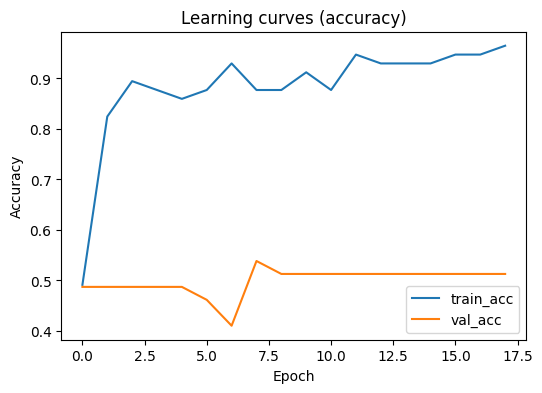

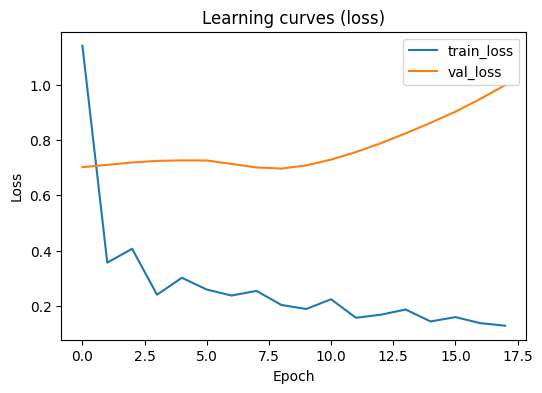

In [12]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning curves (accuracy)')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning curves (loss)')
plt.show()

In [13]:

test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

y_pred_prob = model.predict(ds_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

if y_test.dtype == object:
    label_to_idx = {name: i for i, name in enumerate(class_names)}
    y_test_encoded = y_test.replace(label_to_idx).astype(int)
else:
    y_test_encoded = y_test.copy()

print(classification_report(y_test_encoded, y_pred, target_names=class_names))


Test accuracy: 0.4583
              precision    recall  f1-score   support

       silla       0.48      0.83      0.61        12
     monitor       0.33      0.08      0.13        12

    accuracy                           0.46        24
   macro avg       0.40      0.46      0.37        24
weighted avg       0.40      0.46      0.37        24



C:\Users\jayka\AppData\Local\Temp\ipykernel_18752\2533762047.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_encoded = y_test.replace(label_to_idx).astype(int)


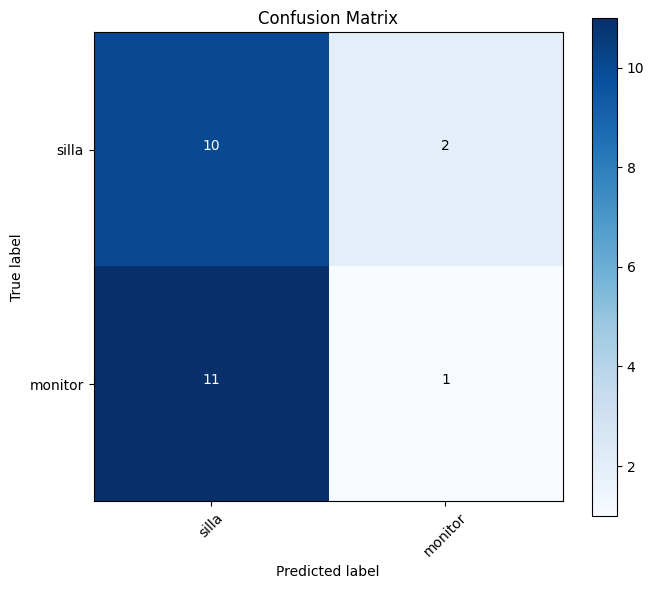

In [14]:
y_test_num = y_test.map(lambda x: class_names.index(x))

cm = confusion_matrix(y_test_num, y_pred)

plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

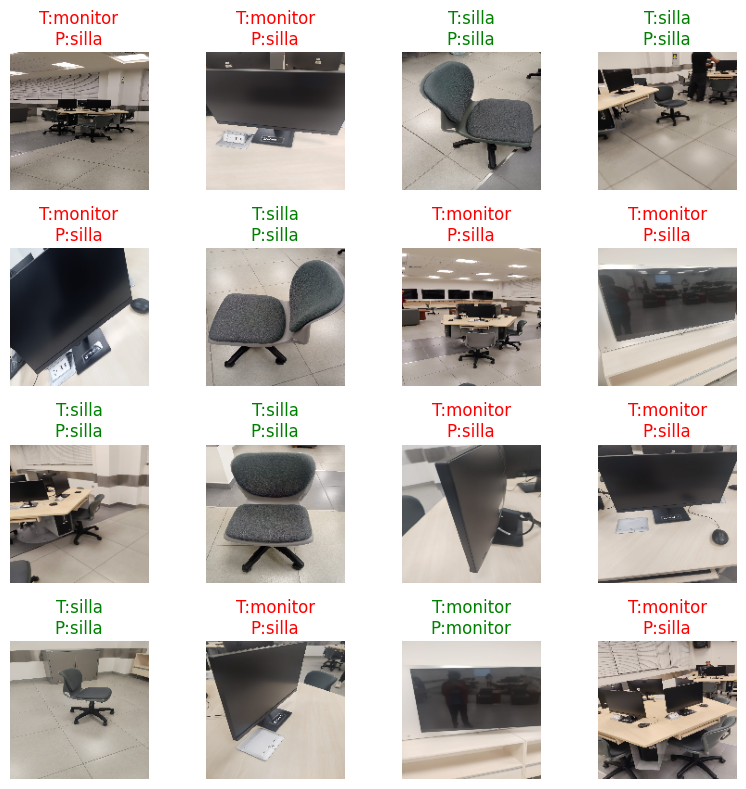

In [15]:
wrong_idx = np.where(y_test != y_pred)[0]
np.random.shuffle(wrong_idx)

n_show = 16
plt.figure(figsize=(8,8))

for i, idx in enumerate(wrong_idx[:n_show]):
    plt.subplot(4,4,i+1)

    img_path = X_test.iloc[idx]
    img = tf.keras.utils.load_img(img_path, target_size=(150,150))
    plt.imshow(img)

    true_label = y_test.iloc[idx]
    pred_label = class_names[y_pred[idx]]

    color = "red" if true_label != pred_label else "green"
    plt.title(f"T:{true_label}\nP:{pred_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()
